<a href="https://colab.research.google.com/github/amanda-araujo/redes-neurais-aprendizado-profundo/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

In [3]:
# AUTOENCODER

# Libraries and packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Autoencoder architecture
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(8, 16,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3,
                            kernel_size=3,
                            stride=2,
                            padding=1,
                            output_padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

# Initialize the autoencoder
model = Autoencoder()

# Define transform (x): ToTensor()
'''Flowers102: unequal tensor sizes; stack expects each tensor to be equal size, but got [3, 620, 500] at entry 0 and [3, 500, 752] at entry 1'''
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load dataset
'''MNIST'''
training_data = MNIST( #60.000 samples for training and 10.000 for testing.
    root="data",       #root: caminho onde os dados serão armazenados localmente
    train=True,        #train: variável binária dados de treinamento (True) e teste (False)
    download=True,     #download: se True faz download da Internet caso os dados não estejam disponíveis localmente
    transform=ToTensor() #transform e target_transform especifica transformações para as features e labels.
)

testing_data = MNIST(
    root="data",
    train=False,        #train: treinamento (True) e teste (False)
    download=True,
    transform=ToTensor()
)

'''Flowers102'''
train_dataset2 = datasets.Flowers102(root='flowers',
                                    split='train',
                                    transform=transform,
                                    download=True)
test_dataset2 = datasets.Flowers102(root='flowers',
                                   split='test',
                                   transform=transform)

print("MNIST format:", training_data[0][0].shape, "Class of the first example:", training_data[0][1])
print("Flowers102 format:", train_dataset2[0][0].shape, "Class of the first example:", train_dataset2[0][1])
#500*764=382000

# Define dataloader
batch_size = 128
'''MNIST'''
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=batch_size)
'''Flowers102'''
train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset2,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader2 = torch.utils.data.DataLoader(dataset=test_dataset2,
                                          batch_size=batch_size)

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  #mean squared error between each element in the input x and target y
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 50

'''Flowers102: 3m55s'''
print("Flowers102:")
for epoch in range(num_epochs):
    for data in train_loader2:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

'''MNIST'''
print("MNIST")
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

MNIST format: torch.Size([1, 28, 28]) Class of the first example: 5
Flowers102 format: torch.Size([3, 64, 64]) Class of the first example: 0
cuda
Flowers102:
Epoch [1/50], Loss: 0.0832
Epoch [6/50], Loss: 0.0782
Epoch [11/50], Loss: 0.0375
Epoch [16/50], Loss: 0.0236
Epoch [21/50], Loss: 0.0173
Epoch [26/50], Loss: 0.0152
Epoch [31/50], Loss: 0.0125
Epoch [36/50], Loss: 0.0124
Epoch [41/50], Loss: 0.0118
Epoch [46/50], Loss: 0.0119
MNIST


RuntimeError: ignored

> Para o conjunto de dados Flowers102, o autoencoder funciona perfeitamente, e a função de perda (loss) diminui conforme passam as *epocs*. Problemas com MNIST... investigando formatos:

In [6]:
# Shape image dataset

'''MNIST'''
print("MNIST--------")

dataiter = iter(test_loader)
imgs, _ = next(dataiter)

# Lets se the shape of 1 image
img = imgs[1]
print("Image shape:", img.shape, '\n')

'''Flowers102'''
print("Flowers102---------")
dataiter = iter(test_loader2)
imgs, _ = next(dataiter)

# Lets se the shape of 1 image
img = imgs[1]
print("Image shape:", img.shape, '\n')

MNIST--------
Image shape: torch.Size([1, 28, 28]) 

Flowers102---------
Image shape: torch.Size([3, 64, 64]) 



A arquitetura do autoencoder é alterada dependendo do tamanho da imagem (input). Nesse caso, Flowers102 tem formato [3, 64, 64] - 3 canais, enquanto MNIST apresenta [1, 28, 28] - apenas 1 canal. Ao tentar aplicar o autoencoder tendo como entrada uma imagem de MNIST obtém se erro:
  
  > "Given groups=1, weight of size [16, 3, 3, 3], expected input[128, 1, 28, 28] to have 3 channels, but got 1 channels instead"




Ou seja, o autoenconder deve ser construído tendo em mente o formato dos dados que a rede receberá e terá de lidar com. O tamanho de entrada da primeira camada da rede (in_channel) deve estar de acordo com o tamanho da imagem do conjunto de dados a ser passado. No caso, aparaentemente in_channels = #número de canais do input.

# Autoencoder: T2 (MNIST)

In [10]:
# Libraries and packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [60]:
# Autoencoder architecture T2
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), #in_channels, out_channels= #filters
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    )

    # flatten: tensor to vector (conv to linear)
    self.linear_encoder = nn.Sequential(
        nn.Linear(64*7*7, 128),
        nn.ReLU()
    )

    self.linear_decoder = nn.Sequential(
        nn.Linear(128, 64*7*7),
        nn.ReLU()
    )

    # (non)flatten: vector to tensor (linear to conv)
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32,
                               kernel_size=2,
                               stride=2),
                               #padding=1,
                               #output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1,
                            kernel_size=2,
                            stride=2),
                            #padding=1,
                            #output_padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    # print("shape initial:")
    # print(x.shape)

    x = self.encoder(x)
    # print("shape after encoder (conv):")
    # print(x.shape)

    # for flattening (to allow use linear layers) we need to change the dimension to a vector
    x = x.view(x.size(0), -1)
    # print("shape after flattening:")
    # print(x.shape)

    x = self.linear_encoder(x)
    # print("shape after encoder (linear):")
    # print(x.shape)

    x = self.linear_decoder(x)
    # print("shape after decoder (linear):")
    # print(x.shape)

    # for the inverse (linear to conv; vector to tensor)
    x = x.view(x.size(0), 64, 7, 7) #64*7*7
    # print("shape after inverse flattening (vector to tensor):")
    # print(x.shape)

    x = self.decoder(x)
    # print("shape after decoder (conv):")
    # print(x.shape)
    return x

In [61]:
# Initialize the autoencoder
model = Autoencoder()

In [ ]:
# Load dataset
'''MNIST'''
training_data = MNIST( #60.000 samples for training and 10.000 for testing.
    root="data",       #root: caminho onde os dados serão armazenados localmente
    train=True,        #train: variável binária dados de treinamento (True) e teste (False)
    download=True,     #download: se True faz download da Internet caso os dados não estejam disponíveis localmente
    transform=ToTensor() #transform e target_transform especifica transformações para as features e labels.
)

testing_data = MNIST(
    root="data",
    train=False,        #train: treinamento (True) e teste (False)
    download=True,
    transform=ToTensor()
)
print("MNIST format:", training_data[0][0].shape, "Class of the first example:", training_data[0][1])

# Define dataloader
batch_size = 128
'''MNIST'''
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=batch_size)

In [62]:
# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_encoder): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
  )
  (linear_decoder): Sequential(
    (0): Linear(in_features=128, out_features=3136, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [63]:
# Define the loss function and optimizer
criterion = nn.BCELoss()  #Binary Cross Entropy between the target and the input probabilities
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 50

'''Flowers102: 3m55s'''
# print("Flowers102:")
# for epoch in range(num_epochs):
#     for data in train_loader2:
#         img, _ = data
#         img = img.to(device)
#         optimizer.zero_grad()
#         output = model(img)
#         loss = criterion(output, img)
#         loss.backward()
#         optimizer.step()
#     if epoch % 5== 0:
#         print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

'''MNIST: 6m22s-7m38s'''
print("MNIST")
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

MNIST
Epoch [1/50], Loss: 0.0984
Epoch [6/50], Loss: 0.0771
Epoch [11/50], Loss: 0.0688
Epoch [16/50], Loss: 0.0677
Epoch [21/50], Loss: 0.0701
Epoch [26/50], Loss: 0.0683
Epoch [31/50], Loss: 0.0665
Epoch [36/50], Loss: 0.0666
Epoch [41/50], Loss: 0.0694
Epoch [46/50], Loss: 0.0675


> Nota-se que com o *learning rate* de 0.001 e a dada configuração do modelo, a função de perda oscila ao invés de convergir para um valor conforme passam as epochs.

Treinando o modelo com *learning rate* de 0.0005:

In [82]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the autoencoder
num_epochs = 50

ep = []
l = []

'''MNIST: 6m22s'''
print("MNIST")
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        # save data
        ep.append(epoch+1)
        l.append(loss.item())
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

MNIST
Epoch [1/50], Loss: 0.0656
Epoch [6/50], Loss: 0.0662
Epoch [11/50], Loss: 0.0644
Epoch [16/50], Loss: 0.0697
Epoch [21/50], Loss: 0.0675
Epoch [26/50], Loss: 0.0678
Epoch [31/50], Loss: 0.0647
Epoch [36/50], Loss: 0.0620
Epoch [41/50], Loss: 0.0701
Epoch [46/50], Loss: 0.0682


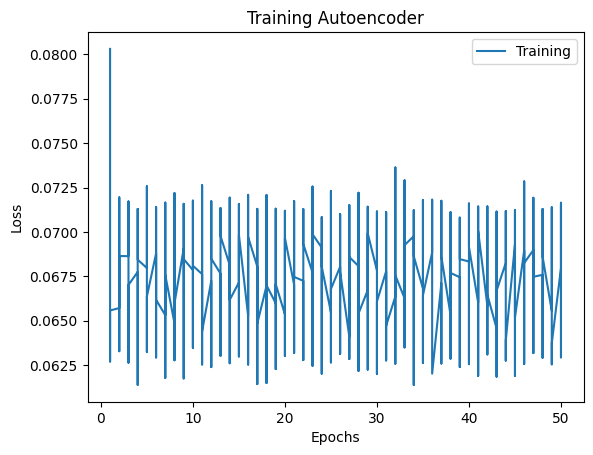

In [84]:
# Remember that we can see how the loss are changing along the epochs
import matplotlib.pyplot as plt

plt.plot(ep, l)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Autoencoder')
plt.legend(['Training'])
plt.show()

> Por alguma razão o modelo não está convergindo para um valor de perda... (?)

Links:
* https://www.geeksforgeeks.org/implement-convolutional-autoencoder-in-pytorch-with-cuda/
* https://pytorch.org/vision/main/generated/torchvision.datasets.Flowers102.html
* https://discuss.pytorch.org/t/how-to-convert-to-linear/93315